# "Calibrating rough volatility models: a Convolutional Neural Network approach" $^1$
$^1$*Henry Stone*


**Author:**
Adel ADRAOUI

**Machine Learning in Finance (ENSAE Paris - IP Paris)**

The goal is to employ a one-dimensional convolutional neural network (1D CNN) to predict the Hölder exponent $H$ for a stochastic process

## Preambule

### Setup and Initial Imports

In this section, we begin by importing necessary libraries and modules that will be used throughout the notebook:

- **Standard libraries**: `time` for timing executions, `logging` for outputting logs.
- **Data handling and scientific computing**: `numpy` and `pandas` for data manipulation, `scipy.special` for special mathematical functions.
- **Visualization and machine learning**: `matplotlib.pyplot` for plotting graphs, and `train_test_split` from `sklearn.model_selection` for splitting data into training and testing sets.
- **Deep learning frameworks**: `tensorflow` and `keras` for building and training neural network models.
  - Within Keras, we specifically import `ModelCheckpoint` and `EarlyStopping` to aid in model training by providing checkpoint saving and early stopping functionalities, respectively.
- **Fractional Brownian Motion**: The `fbm` library is used for generating simulations of fractional Brownian motion, which is essential for modeling scenarios in fields like finance or physics where memory and persistence characteristics are necessary.

In [72]:
# Import essential libraries
import time
import logging
import numpy as np
import pandas as pd
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Enable inline plotting for Jupyter
%matplotlib inline

# Import TensorFlow and Keras
import tensorflow as tf
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.models import load_model


# Import from the 'fbm' for fractional Brownian motion
from fbm import FBM

# Configure logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

### Generating Rough Bergomi Paths

This function is designed to generate paths according to the rough Bergomi model, a stochastic model used to simulate the rough volatility dynamics often observed in financial markets. The implementation involves several key steps:

1. **Time Partitioning**: We create an array of time steps over the specified horizon, `T`.
2. **Covariance Matrix Calculation**: A covariance matrix is constructed to capture the self-similarity and long-range dependence characteristics of the fractional Brownian motion, parameterized by the Hurst index `H`.
3. **Cholesky Decomposition**: This step involves decomposing the covariance matrix into a lower triangular matrix, which helps in generating correlated Gaussian random variables in the next step.
4. **Random Variable Generation**: Gaussian random variables are generated, which are then transformed using the Cholesky matrix to create paths that exhibit the statistical properties dictated by the Hurst index.
5. **Scaling and Adjustments**: The paths are scaled according to the time horizon and the `eta` parameter to ensure they reflect the correct time-scaling and volatility characteristics.

Each path starts from zero and evolves over time, providing a simulated trajectory of volatility according to the rough Bergomi model parameters. This simulation is crucial for testing and calibrating financial models that attempt to predict or hedge against the volatility of financial instruments.


In [3]:
def generate_rBergomi_paths(n_paths, n_timesteps, hurst_index, time_horizon=1, eta=1):
    """Generates rough Bergomi paths with specified parameters, using the Cholesky decomposition method.
    Source: https://github.com/amuguruza/RoughFCLT/blob/master/rDonsker.ipynb
    
    Parameters:
    -----------
    n_paths : int
        Number of paths to generate.
    n_timesteps : int
        Number of time steps of the path.
    hurst_index : float
        Hurst index (H), must be in the interval (0, 1).
    time_horizon : float, optional
        Total time horizon (T), default is 1.
    eta : float, optional
        Scaling parameter eta, default is 1.
    
    Returns:
    --------
    numpy.ndarray
        A 2D array of shape [n_paths, n_timesteps] containing the generated paths.
    """
    assert 0 < hurst_index < 1, "Hurst index must be between 0 and 1."
    
    # Step 1: Create time partition
    time_steps = np.linspace(0, time_horizon, num=n_timesteps)[1:]
    
    # Step 2: Compute the covariance matrix
    covariance_matrix = np.zeros((n_timesteps - 1, n_timesteps - 1))
    for i in range(covariance_matrix.shape[0]):
        covariance_matrix[i, i] = np.power(time_steps[i], 2 * hurst_index) / (2 * hurst_index)
        for j in range(i + 1, covariance_matrix.shape[1]):
            s, t = time_steps[i], time_steps[j]
            covariance_matrix[i, j] = (np.power(t - s, hurst_index - 0.5) / (hurst_index + 0.5) * 
                                       np.power(s, 0.5 + hurst_index) * 
                                       special.hyp2f1(0.5 - hurst_index, 0.5 + hurst_index, 1.5 + hurst_index, -s / (t - s)))
            covariance_matrix[j, i] = covariance_matrix[i, j]
    
    # Step 3: Compute the Cholesky decomposition
    cholesky_matrix = np.linalg.cholesky(covariance_matrix)
    
    # Step 4: Draw Gaussian random variables
    gaussian_randoms = np.random.normal(loc=0.0, scale=1.0, size=[n_paths, n_timesteps - 1])
    
    # Step 5: Generate the paths using matrix multiplication
    brownian_paths = gaussian_randoms.dot(cholesky_matrix.T)
    
    # Adjust paths by scaling for time horizon and eta
    paths = brownian_paths * np.power(time_horizon, hurst_index) * eta * np.sqrt(2 * hurst_index)
    
    # Insert a zero column at the beginning to start paths from 0
    paths = np.insert(paths, 0, 0, axis=1)
    
    return paths

### Generating Randomized Rough Bergomi Paths

This function is tailored for generating trajectories of the Z process in the rough Bergomi model (rBergomi model) with parameters sampled from probability distributions:

1. **$\eta$ (~ Uniform([0,3]))**: This parameter scales the intensity of the volatility. It is drawn from a uniform distribution ranging from 0 to 3 for each trajectory, allowing for a wide range of volatility behaviors.
2. **H (~ Beta(1, 9))**: The Hurst index 'H' dictates the roughness of the volatility path. It is sampled from a beta distribution, which in this case skews towards lower values (favoring more roughness), due to the shape parameters 1 and 9.

**Steps to Generate Paths**

- **Parameter Sampling**: For each trajectory, draw the eta and H values from their respective distributions.
- **Path Generation**: For each set of sampled parameters, generate a trajectory using the previously defined function `generate_rBergomi_paths`. This function takes into account the specificities of fractional Brownian motion that underlies the rBergomi model.
- **Validation**: After generating the paths, we assert that the output array's shape is as expected, confirming that the path generation process was executed correctly.

**Output**

The function returns a tuple containing:
- The matrix of paths where each row corresponds to a simulated trajectory.
- The arrays of Hurst indices and eta values used in generating these paths.

In [4]:
def generate_rBergomi_random_paths(n_paths, n_timesteps=100):
    """Generates multiple trajectories of the Z process in the rough Bergomi (rBergomi) model with random parameters.
    Parameters are drawn from uniform and beta distributions for eta and Hurst index H, respectively.
    
    Parameters:
    -----------
    n_paths : int
        Number of paths to generate.
    n_timesteps : int, optional
        Number of time steps in each path, default is 100.
    
    Returns:
    --------
    tuple
        A tuple containing:
        - paths (numpy.ndarray): A 2D array of shape [n_paths, n_timesteps] containing the generated paths.
        - Hs (numpy.ndarray): An array of randomly generated Hurst indices.
        - etas (numpy.ndarray): An array of randomly generated eta values.
    """
    # Generate random parameters for each path
    etas = np.random.uniform(0, 3, n_paths)
    Hs = np.random.beta(1, 9, n_paths)

    # Generate paths using the previously defined function for each set of parameters
    paths = np.array([generate_rBergomi_paths(1, n_timesteps, Hs[i], eta=etas[i])[0] for i in range(n_paths)])

    # Verify the shape of the generated paths array
    assert paths.shape == (n_paths, n_timesteps), "Shape mismatch in generated paths"

    return paths, Hs, etas

### Least Squares of Lagged Differences

1. **`compute_lagged_mean`**: Computes the mean of the absolute differences between lagged terms of a time series, raised to a specified power.

2. **`fit_least_squares_to_logs`**: Performs a logarithmic transformation on the averages computed by `compute_lagged_mean` and fits a linear regression to these log-transformed values against the logarithm of their corresponding lags.

3. **`estimate_path_parameters`**: Aggregates the slopes of log-log regressions across different powers to further fit and retrieve significant parameters that describe the overall trend in the scaling behavior of the time series.

4. **`perform_least_squares_analysis`**: Applies the full analysis procedure to multiple time series paths, facilitating batch processing and analysis.

In [5]:
def compute_lagged_mean(path, power, lag):
    """Computes the mean of the powered lagged differences of a path.
    
    Parameters:
    -----------
    path : numpy.ndarray
        The one-dimensional path array.
    power : float
        The power to raise the lagged differences.
    lag : int
        The number of steps to lag for difference computation.
    
    Returns:
    --------
    float
        Mean of the powered lagged differences.
    """
    differences = np.abs(path[lag:] - path[:-lag])
    powered_differences = np.power(differences, power)
    return np.mean(powered_differences)

def fit_least_squares_to_logs(q, logs, path):
    """Helper function to compute the slope of log-log regression for a given q.
    
    Parameters:
    -----------
    q : float
        Power for the lagged differences.
    logs : numpy.ndarray
        Logarithm of the lag indices.
    path : numpy.ndarray
        The path for which statistics are computed.
    
    Returns:
    --------
    float
        The slope of the log-log linear regression.
    """
    avgs = [compute_lagged_mean(path, q, lag) for lag in range(1, 31)]
    avgs_log = np.log(avgs)
    return np.polyfit(logs, avgs_log, 1)[0]

def estimate_path_parameters(path):
    """Estimates parameters for a given path using least squares fit on log-log data.
    
    Parameters:
    -----------
    path : numpy.ndarray
        The path to analyze.
    
    Returns:
    --------
    tuple
        Parameters (slope and intercept) of the fit.
    """
    powers = [0.5, 1.0, 1.5, 2.0, 3.0]
    logs = np.log(np.arange(1, 31))
    slopes = [fit_least_squares_to_logs(q, logs, path) for q in powers]
    return np.polyfit(powers, slopes, 1)[:2]

def perform_least_squares(paths):
    """Applies least squares analysis across multiple paths.
    
    Parameters:
    -----------
    paths : numpy.ndarray
        Array of paths to analyze.
    
    Returns:
    --------
    numpy.ndarray
        Array of estimated parameters for each path.
    """
    return np.apply_along_axis(estimate_path_parameters, 1, paths.reshape(paths.shape[:2]))

### Sampling and Shuffling Functions for Hurst Exponents

1. **`generate_h_values`**: Generates a list of Hurst exponents using various predefined distributions.

2. **`shuffle_arrays_together`**: Jointly shuffles two arrays to maintain the pairing between elements of each array, which is crucial when the indices represent linked data (e.g., labels and features in machine learning).

In [6]:
import numpy as np

def generate_h_values(method='discretized'):
    """Generates a list of Hurst exponents (H) using different sampling methods.
    
    Parameters:
    -----------
    method : str
        Method to generate Hurst exponents. Options include 'discretized', 'uniform', and 'beta'.
    
    Returns:
    --------
    list
        List of Hurst exponents.
    
    Raises:
    -------
    ValueError
        If the specified method is not supported.
    """
    if method == 'discretized':
        return [0.1, 0.2, 0.3, 0.4, 0.5]
    elif method == 'uniform':
        return list(np.random.uniform(0, 0.5, size=5))
    elif method == 'beta':
        return list(np.random.beta(1, 9, size=5))
    else:
        raise ValueError("Unsupported method specified: {}".format(method))

def shuffle_arrays_together(array1, array2):
    """Shuffles two arrays in the same order.
    
    Parameters:
    -----------
    array1 : numpy.ndarray
        First array to shuffle.
    array2 : numpy.ndarray
        Second array to shuffle jointly with the first array.
    
    Returns:
    --------
    tuple
        A tuple containing the shuffled arrays.
    
    Raises:
    -------
    AssertionError
        If the input arrays do not have the same length.
    """
    assert len(array1) == len(array2), "Arrays must have the same length"
    shuffle_indices = np.random.permutation(len(array1))
    return array1[shuffle_indices], array2[shuffle_indices]


### Convolutional Neural Network Architecture

- **Input Layer**: Accepts sequences of the specified `input_length`, each with a single feature (e.g., a univariate time series).
- **Convolutional Layers**: Three layers with increasing numbers of filters (32, 64, and 128), using linear activation and `same` padding to maintain the sequence length post-convolution. These layers are responsible for extracting high-level features from the input data.
- **Activation Function**: LeakyReLU is used to introduce non-linearity without impeding the flow of gradients during training, especially useful for avoiding the "dying ReLU" problem.
- **Pooling Layers**: Max pooling is applied after each convolutional layer to reduce dimensionality and focus on the most prominent features, improving the network's generalization capabilities.
- **Dropout Layers**: Applied after each pooling step and before the final dense layer to prevent overfitting by randomly dropping a fraction of the nodes.
- **Output Layer**: A dense layer with a `sigmoid` activation function, designed to output predictions for binary classification or regression tasks depending on the `output_length`.


In [7]:
import keras as K

def build_neural_network(input_length=100, kernel_size=20, pool_size=3, leaky_rate=0.1, output_length=1):
    """Constructs a convolutional neural network (CNN) architecture for time-series analysis.
    
    Parameters:
    -----------
    input_length : int, optional
        Length of the input time series data. Default is 100.
    kernel_size : int, optional
        Size of the convolution kernel. Default is 20.
    pool_size : int, optional
        Size of the pooling window. Default is 3.
    leaky_rate : float, optional
        Negative slope coefficient for LeakyReLU activation. Default is 0.1.
    output_length : int, optional
        Dimension of the output layer. Default is 1.
    
    Returns:
    --------
    keras.Model
        The constructed Keras sequential model.
    """
    model = K.models.Sequential([
        K.Input(shape=(input_length, 1)),
        K.layers.Conv1D(32, kernel_size, activation='linear', padding='same'),
        K.layers.LeakyReLU(negative_slope=leaky_rate),
        K.layers.MaxPool1D(pool_size, padding='same'),
        K.layers.Dropout(rate=0.25),
        K.layers.Conv1D(64, kernel_size, activation='linear', padding='same'),
        K.layers.LeakyReLU(negative_slope=leaky_rate),
        K.layers.MaxPool1D(pool_size, padding='same'),
        K.layers.Dropout(rate=0.25),
        K.layers.Conv1D(128, kernel_size, activation='linear', padding='same'),
        K.layers.LeakyReLU(negative_slope=leaky_rate),
        K.layers.MaxPool1D(pool_size, padding='same'),
        K.layers.Dropout(rate=0.4),
        K.layers.Flatten(),
        K.layers.Dense(128, activation='linear'),
        K.layers.LeakyReLU(negative_slope=leaky_rate),
        K.layers.Dropout(rate=0.3),
        K.layers.Dense(output_length, activation='sigmoid')
    ])
    return model

### Data Preparation Functions for CNN

These functions are designed to streamline the process of preparing datasets for training neural networks, specifically tailored for time-series data analysis involving stochastic processes. Here's a breakdown of each function's purpose and implementation:

1. **`joint_shuffle`**: Jointly shuffles two associated arrays (e.g., features and labels) to maintain their correspondence, which is critical for maintaining data integrity in machine learning workflows.

2. **`shuffle_and_split_data`**: Shuffles and splits the dataset into training, validation, and testing sets, ensuring that each set is representative of the overall dataset.

3. **`prepare_dataset`**: Generates paths based on stochastic processes (either rough Bergomi or fractional Brownian motion) and prepares them for neural network training by shuffling and splitting.


In [8]:
def joint_shuffle(array1, array2):
    """Randomly shuffles two arrays jointly.
    
    Parameters:
    -----------
    array1 : numpy.ndarray
        The first array to shuffle.
    array2 : numpy.ndarray
        The second array to shuffle jointly with the first array.
    
    Returns:
    --------
    tuple
        A tuple of the shuffled arrays.
    """
    assert len(array1) == len(array2), "Arrays must have the same length"
    shuffled_indices = np.random.permutation(len(array1))
    return array1[shuffled_indices], array2[shuffled_indices]

def shuffle_and_split_data(paths, labels):
    """Shuffles a dataset and splits it into training, validation, and testing sets.
    
    Parameters:
    -----------
    paths : numpy.ndarray
        The dataset containing all the path data.
    labels : numpy.ndarray
        The corresponding labels for the dataset.
    
    Returns:
    --------
    tuple
        Six arrays: X_train, X_val, X_test, Y_train, Y_val, Y_test
    """
    paths, labels = joint_shuffle(paths, labels)
    paths = paths.reshape((paths.shape[0], paths.shape[1], 1))
    labels = labels.reshape((labels.shape[0], -1))
    
    X_train, X_test, Y_train, Y_test = train_test_split(paths, labels, test_size=0.3)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

def prepare_dataset(Hs, method='rbergomi', n_paths=5000, n_timesteps=500, T=1, eta=1):
    """Prepares dataset for neural network by generating paths and splitting into datasets.
    
    Parameters:
    -----------
    Hs : list
        List of Hurst indices to use for path generation.
    method : str, optional
        The method to generate paths ('rbergomi' or 'fbm'). Default is 'rbergomi'.
    n_paths : int, optional
        Number of paths to generate per Hurst index. Default is 5000.
    n_timesteps : int, optional
        Number of time steps in each path. Default is 500.
    T : float, optional
        Total time horizon. Default is 1.
    eta : float, optional
        Scaling parameter eta. Default is 1.
    
    Returns:
    --------
    tuple
        Six arrays: X_train, X_val, X_test, Y_train, Y_val, Y_test
    """
    paths = np.zeros((n_paths * len(Hs), n_timesteps), dtype=float)
    labels = np.zeros(n_paths * len(Hs), dtype=float)
    
    if method == 'rbergomi':
        for H_idx, H in enumerate(Hs):
            generated_paths = generate_rBergomi_paths(n_paths, n_timesteps, H, T, eta)
            paths[H_idx * n_paths:(H_idx + 1) * n_paths] = generated_paths
            labels[H_idx * n_paths:(H_idx + 1) * n_paths] = H
    elif method == 'fbm':
        for H_idx, H in enumerate(Hs):
            path_generator = FBM(n=n_timesteps-1, hurst=H, length=T, method='cholesky')
            for i in range(n_paths):
                paths[H_idx * n_paths + i] = path_generator.fbm()
            labels[H_idx * n_paths:(H_idx + 1) * n_paths] = H
    
    return shuffle_and_split_data(paths, labels)


### CNN Training and Benchmarking Procedure

The `benchmark` function performs the following key operations:

1. **Model Setup and Training**:
   - Constructs and compiles a CNN with specified architectural parameters such as kernel size, pooling size, and activation functions.
   - Trains the CNN on training data while validating on a separate validation set to monitor performance and prevent overfitting.
   
2. **Performance Evaluation**:
   - Evaluates the trained model on a test dataset to compute performance metrics.
   - Compares these metrics against those obtained from a least squares regression method.

3. **Data Recording**:
   - Stores performance metrics for each input length in a DataFrame for easy analysis and reporting.

**Key Parameters and Variables**

- **`X_train, Y_train, X_val, Y_val, X_test, Y_test`**: Training, validation, and test datasets.
- **`kernel_size, pool_size, leaky_rate`**: Architectural parameters of the CNN.
- **`batch_size, n_epochs`**: Training parameters defining the batch size and the number of epochs.

**Performance Metrics**
- **Root Mean Squared Error (RMSE)**:
  $$
  RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
  $$
  where \( y_i \) are the true values and \( \hat{y}_i \) are the predicted values by the model.

- **Mean Relative Error (MRE)**:
  $$
  MRE = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{y_i - \hat{y}_i}{y_i}\right|
  $$
  which measures the average magnitude of the relative errors between the predicted and actual values.


In [49]:
def benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test, kernel_size=20, pool_size=3, leaky_rate=0.3, 
              batch_size=64, n_epochs=30, verbose=0, time_steps=[100, 200, 300, 400, 500]):
    """
    Performs training and evaluation of a CNN across different input lengths and benchmarks against least squares.

    Parameters:
    -----------
    X_train, Y_train, X_val, Y_val, X_test, Y_test : numpy.ndarray
        Training, validation, and test sets.
    kernel_size, pool_size : int
        Kernel and pool sizes for the CNN layers.
    leaky_rate : float
        Leaky ReLU activation negative slope.
    batch_size : int
        Batch size for training the CNN.
    n_epochs : int
        Number of epochs for CNN training.
    verbose : int
        Verbosity mode for training output.
    time_steps : list
        Different input lengths to benchmark on.

    Returns:
    --------
    tuple
        A tuple containing the DataFrame of benchmarks and a dictionary of loss histories.
    """
    # DataFrame to store the performance metrics
    report = pd.DataFrame(columns=['RMSE(CNN)', 'MRE(CNN)', 'Training Time (seconds)', 'Test Time (seconds)',
                                   'RMSE(LS)', 'MRE(LS)', 'Time (seconds)'], index=time_steps)
    report.index.name = 'Input length'
    loss_history = {}

    for n_timesteps in time_steps:
        logging.info("Processing {} time steps".format(n_timesteps))

        # Setup and compile the model
        model = build_neural_network(n_timesteps, kernel_size, pool_size, leaky_rate)
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Slice the datasets to match the current timestep
        X_train_t = X_train[:, :n_timesteps]
        X_val_t = X_val[:, :n_timesteps]
        X_test_t = X_test[:, :n_timesteps]
        
        # Train the CNN
        logging.info("Training CNN")
        start_time = time.time()
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=verbose, mode='auto')
        cnn_train = model.fit(X_train_t, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                              validation_data=(X_val_t, Y_val), callbacks=[early_stopping])
        cnn_train_time = time.time() - start_time

        # Record training time and perform prediction
        report.loc[n_timesteps, 'Training Time (seconds)'] = cnn_train_time
        start_time = time.time()
        cnn_pred = model.predict(X_test_t)
        cnn_test_time = time.time() - start_time
        report.loc[n_timesteps, 'Test Time (seconds)'] = cnn_test_time

        # Calculate and record performance metrics
        report.loc[n_timesteps, 'RMSE(CNN)'] = np.sqrt(mean_squared_error(Y_test, cnn_pred))
        report.loc[n_timesteps, 'MRE(CNN)'] = mean_absolute_error(Y_test, cnn_pred) / np.mean(Y_test)

        # Store the loss history for later analysis
        loss_history[n_timesteps] = {'train_loss': cnn_train.history['loss'], 'val_loss': cnn_train.history['val_loss']}

        # Perform Least Squares analysis
        logging.info("Evaluating Least Squares")
        start_time = time.time()
        ls_pred = perform_least_squares(X_test_t)[:, 0]
        ls_time = time.time() - start_time

        # Record Least Squares metrics
        report.loc[n_timesteps, 'Time (seconds)'] = ls_time
        report.loc[n_timesteps, 'RMSE(LS)'] = np.sqrt(mean_squared_error(Y_test, ls_pred))
        report.loc[n_timesteps, 'MRE(LS)'] = mean_absolute_error(Y_test, ls_pred) / np.mean(Y_test)
        
        
        # break # this break was used just to stop when we get the first model for an input lenght 100 for next sections 

    return report, loss_history, model

In [32]:
def plot_learning_curves(loss_history, title_prefix=''):
    """plot function for learning curves"""
    n_plots = len(loss_history)
    nrows = int(np.ceil(n_plots / 2))
    plt.figure(figsize=(10, nrows*3))
    
    # Find the global maximum loss to set a consistent scale
    max_loss = max(max(losses['train_loss'] + losses['val_loss']) for losses in loss_history.values())
    
    for plot_idx, (title_suffix, losses) in enumerate(loss_history.items()):
        ax = plt.subplot(nrows, 2, plot_idx+1)
        
        epochs = range(len(losses['train_loss']))
        ax.plot(epochs, losses['train_loss'], color='blue', linestyle='-', marker='s', label='Training loss', alpha=0.7)
        ax.plot(epochs, losses['val_loss'], color='red', linestyle='--', marker='o', label='Validation loss', alpha=0.7)
        
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Mean Squared Loss')
        ax.set_title(f'{title_prefix} = {title_suffix}')
        ax.legend(loc='upper right')
        
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
        
        # Set the y-axis limits
        ax.set_ylim(0, max_loss * 1.05)  # Adding 5% padding for better visibility of the line at the top
        
    plt.tight_layout()
    plt.show()

## 4.1. rBergomi Model

### Discretized H

In this section, $H$ is discretized fixed values: [0.1, 0.2, 0.3, 0.4, 0.5]

1. **Hurst Indices Generation**:
   - The Hurst indices are generated using a discretized sampling method. This method is particularly suited for scenarios where specific, fixed values are needed for simulation consistency.

    $$
    \text{Hurst indices} = \text{generate_h_values(method='discretized')}
    $$

2. **Dataset Preparation**:
   - The dataset is prepared using the rough Bergomi (rBergomi) model, which simulates paths based on the generated Hurst indices.

    $$
    X_{\text{train}}, X_{\text{val}}, X_{\text{test}}, Y_{\text{train}}, Y_{\text{val}}, Y_{\text{test}} = \text{prepare_dataset}(Hs, \text{method='rbergomi'}, n_{\text{paths}}, n_{\text{timesteps}}, T)
    $$

In [51]:
T = 1
n_timesteps = 500
n_paths = 5000

# Generating Hurst indices using the discretized method
Hs = generate_h_values(method='discretized')

# Preparing the data using the rBergomi method for generating paths
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(Hs, method='rbergomi', n_paths=n_paths, n_timesteps=n_timesteps, T=T)

- **`kernel_size`**: Size of the kernel for convolution layers, set to 20.
- **`pool_size`**: Size of the pooling window, set to 3.
- **`leaky_rate`**: Coefficient for the LeakyReLU activation function, set to 0.1.
- **`batch_size`**: Number of samples per batch of computation, set to 64.
- **`n_epochs`**: Number of epochs to train the model, set to 30.

In [52]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Conducting the benchmark to evaluate the performance of the CNN and compare with Least Squares method
report, loss_history, model_h_discretized = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs)

2024-05-03 09:55:24,093 - INFO - Processing 100 time steps
2024-05-03 09:55:24,156 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


2024-05-03 09:58:09,613 - INFO - Evaluating Least Squares


In [59]:
model_h_discretized.save('cnn_model_discretized.h5')
model_h_discretized.save('cnn_model_discretized.keras')

2024-05-03 10:04:25,468 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


- **`report`**: A DataFrame containing detailed performance metrics such as RMSE and MRE for both the CNN and the Least Squares methods across different input lengths.

In [37]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.00909,0.020766,165.742006,1.779151,0.0972,0.252257,20.578377
200,0.00933,0.022982,177.375409,5.240274,0.067238,0.174995,18.580015
300,0.008596,0.020045,183.283934,5.243668,0.054328,0.142008,25.7866
400,0.005317,0.013506,318.955569,5.238449,0.046768,0.121416,30.209298
500,0.012128,0.033577,240.045785,5.225704,0.041703,0.108247,33.243729


- **`loss_history`**: A dictionary storing the training and validation loss history for each input length, aiding in the analysis of the model's learning process.

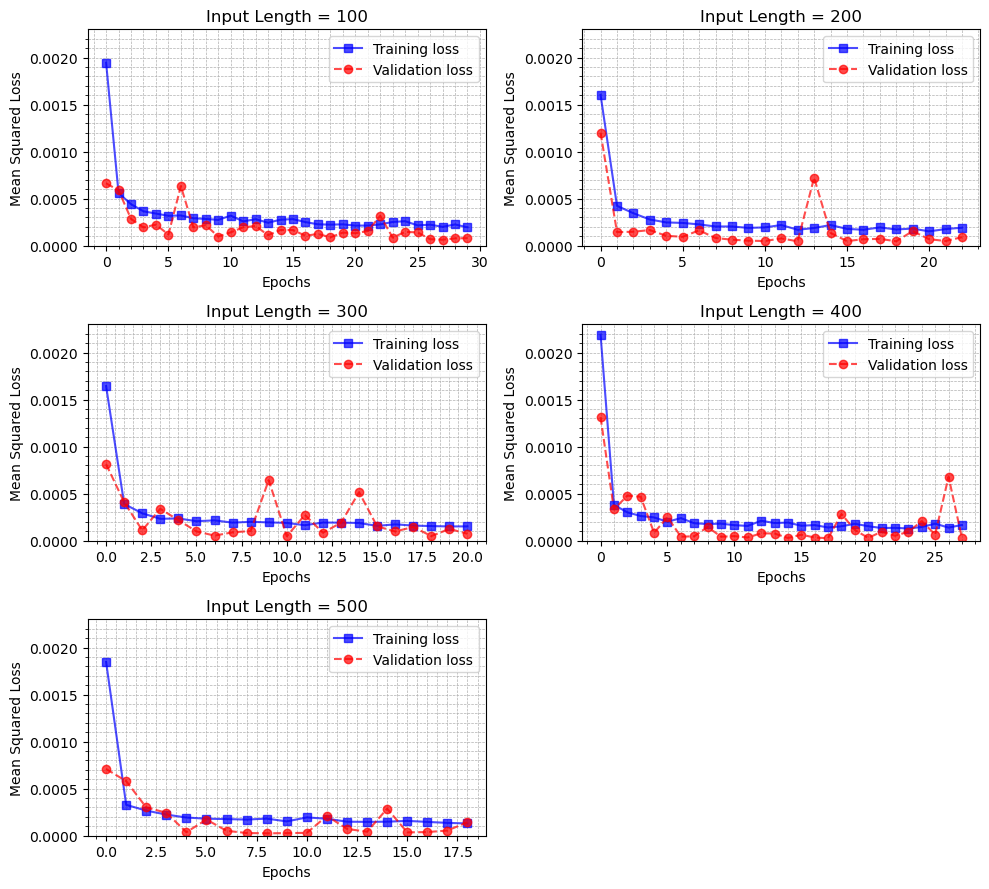

<Figure size 640x480 with 0 Axes>

In [38]:
plot_learning_curves(loss_history, title_prefix='Input Length')

### Uniform H

In this section, $H$ is generated from a uniform distribution $\mathcal{U}([0, 0.5])$

1. **Hurst Indices Generation**:
    $$
    \text{Hurst indices} = \text{generate_h_values(method='uniform')}
    $$

2. **Dataset Preparation**:
    $$
    X_{\text{train}}, X_{\text{val}}, X_{\text{test}}, Y_{\text{train}}, Y_{\text{val}}, Y_{\text{test}} = \text{prepare_dataset}(Hs, \text{method='rbergomi'}, n_{\text{paths}}, n_{\text{timesteps}}, T)
    $$

In [53]:
T = 1
n_timesteps = 500
n_paths = 5000

# Generating Hurst indices using the discretized method
Hs = generate_h_values(method='uniform')
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(Hs, 'rbergomi', n_paths=n_paths, n_timesteps=n_timesteps, T=T)

- **`kernel_size`**: Size of the kernel for convolution layers, set to 20.
- **`pool_size`**: Size of the pooling window, set to 3.
- **`leaky_rate`**: Coefficient for the LeakyReLU activation function, set to 0.1.
- **`batch_size`**: Number of samples per batch of computation, set to 64.
- **`n_epochs`**: Number of epochs to train the model, set to 30.

In [54]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Conducting the benchmark to evaluate the performance of the CNN and compare with Least Squares method
report, loss_history, model_h_uniform = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs)

2024-05-03 09:58:48,552 - INFO - Processing 100 time steps
2024-05-03 09:58:48,597 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


2024-05-03 10:01:14,683 - INFO - Evaluating Least Squares


In [58]:
model_h_uniform.save('cnn_model_uniform.h5')
model_h_uniform.save('cnn_model_uniform.keras')

2024-05-03 10:04:25,402 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


- **`report`**: A DataFrame containing detailed performance metrics such as RMSE and MRE for both the CNN and the Least Squares methods across different input lengths.

In [41]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.013401,0.027848,118.4869,1.460338,0.108061,0.23475,12.435308
200,0.008632,0.018236,189.341019,2.658936,0.073224,0.159898,24.608549
300,0.014434,0.03114,229.793702,5.250767,0.060201,0.130836,29.134474
400,0.00879,0.01866,218.198038,5.239461,0.051546,0.111919,29.7833
500,0.010147,0.022518,376.846676,5.272251,0.046271,0.1008,34.277293


- **`loss_history`**: A dictionary storing the training and validation loss history for each input length, aiding in the analysis of the model's learning process.

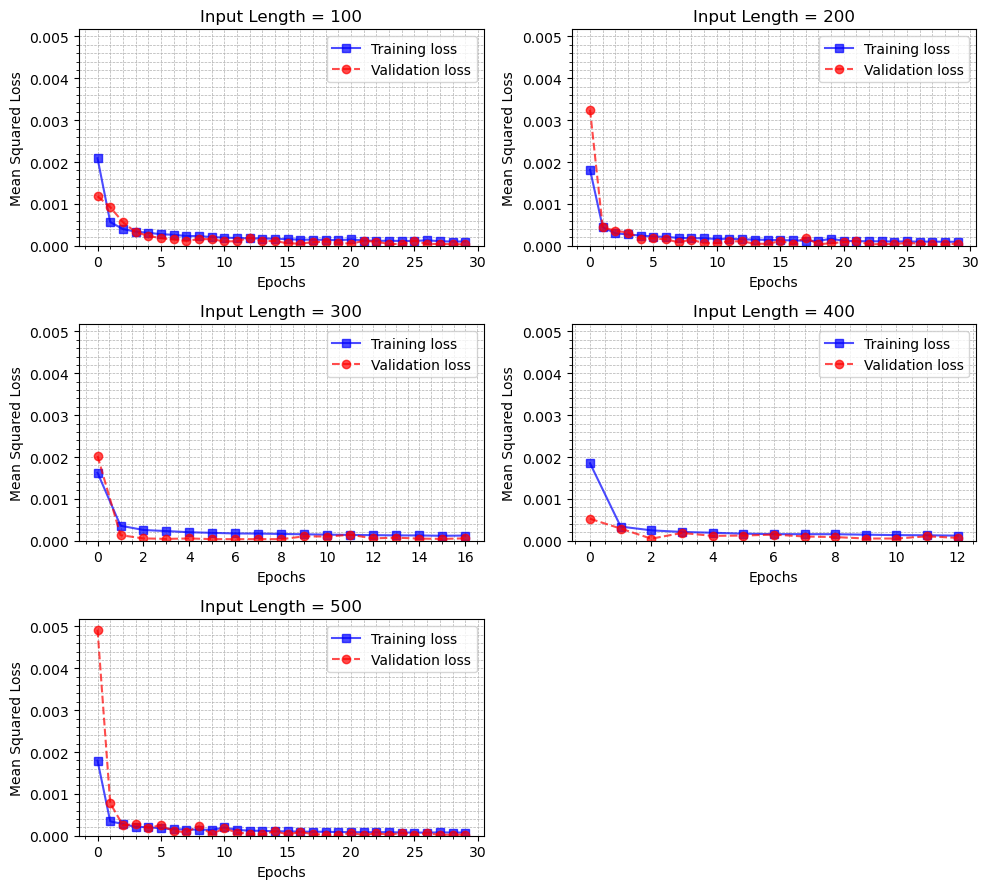

In [51]:
plot_learning_curves(loss_history, title_prefix='Input Length')

### Beta H

In this section $H$ is generated from a $Beta(1, 9)$ distribution

1. **Hurst Indices Generation**:
    $$
    \text{Hurst indices} = \text{generate_h_values(method='beta')}
    $$

2. **Dataset Preparation**:
    $$
    X_{\text{train}}, X_{\text{val}}, X_{\text{test}}, Y_{\text{train}}, Y_{\text{val}}, Y_{\text{test}} = \text{prepare_dataset}(Hs, \text{method='rbergomi'}, n_{\text{paths}}, n_{\text{timesteps}}, T)
    $$

In [55]:
T = 1
n_timesteps = 500
n_paths = 5000

# Generating Hurst indices using the discretized method
Hs = generate_h_values(method='beta')
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(Hs, 'rbergomi', n_paths=n_paths, n_timesteps=n_timesteps, T=T)

- **`kernel_size`**: Size of the kernel for convolution layers, set to 20.
- **`pool_size`**: Size of the pooling window, set to 3.
- **`leaky_rate`**: Coefficient for the LeakyReLU activation function, set to 0.1.
- **`batch_size`**: Number of samples per batch of computation, set to 64.
- **`n_epochs`**: Number of epochs to train the model, set to 30.

In [56]:
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Conducting the benchmark to evaluate the performance of the CNN and compare with Least Squares method
report, loss_history, model_h_beta = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs)

2024-05-03 10:01:40,111 - INFO - Processing 100 time steps
2024-05-03 10:01:40,159 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


2024-05-03 10:04:03,268 - INFO - Evaluating Least Squares


In [57]:
model_h_beta.save('cnn_model_beta.h5')
model_h_beta.save('cnn_model_beta.keras')

2024-05-03 10:04:25,341 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


- **`report`**: A DataFrame containing detailed performance metrics such as RMSE and MRE for both the CNN and the Least Squares methods across different input lengths.

In [19]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.009676,0.021335,115.776889,2.666755,0.096879,0.250381,21.631068
200,0.010599,0.024733,174.199173,2.036729,0.066957,0.172204,27.426104
300,0.006638,0.01527,155.724013,2.374793,0.053647,0.138451,22.836049
400,0.010184,0.027251,238.365431,5.240909,0.046259,0.119394,28.660955
500,0.007941,0.019449,298.936325,4.465656,0.041602,0.107358,32.20853


- **`loss_history`**: A dictionary storing the training and validation loss history for each input length, aiding in the analysis of the model's learning process.

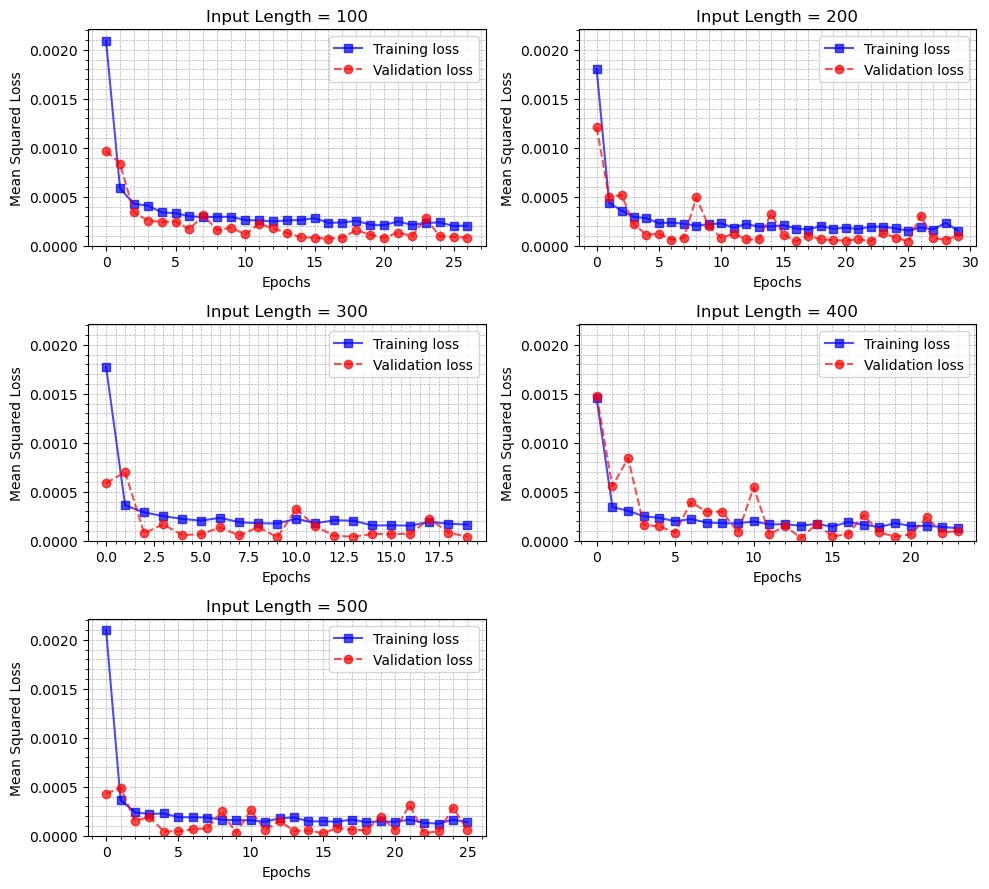

In [20]:
plot_learning_curves(loss_history, title_prefix='Input Length')

## 4.2. Robustness Test
In this section, we allow $\eta$ to vary, instead of setting it fixed to 1 as above. $H$ is fixed with discretized values.

In [44]:
T = 1
n_timesteps = 100
n_paths = 5000

# Generate Hurst indices using a discretized method
Hs = generate_h_values(method='discretized')

# Set different eta values for simulation
etas = [0.25, 0.8, 1.3, 2.5]

# Set neural network parameters
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Initialize DataFrame to store benchmark results for different etas
report_eta = pd.DataFrame(columns=['RMSE(CNN)', 'MRE(CNN)', 'Training Time (seconds)', 'Test Time (seconds)',
                                   'RMSE(LS)', 'MRE(LS)', 'Time (seconds)'], index=etas)
report_eta.index.name = 'eta'

# Dictionary to store loss history for each eta
loss_history_eta = {}

for eta in etas:
    logging.info(f"Performing paths with eta = {eta}")
    X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(Hs, 'rbergomi', n_paths, n_timesteps, T, eta)
    
    # Benchmark the model for each eta and capture the first row (only one timestep of 100 is used)
    report, loss_history, model = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                     kernel_size, pool_size, leaky_rate, batch_size, n_epochs, time_steps=[100])
    
    # Store results in the report DataFrame for each eta
    report_eta.loc[eta, :] = report.iloc[0, :]
    loss_history_eta[eta] = loss_history[100]

2024-05-03 03:35:37,133 - INFO - Performing paths with eta = 0.25
2024-05-03 03:35:37,292 - INFO - Processing 100 time steps
2024-05-03 03:35:37,325 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-05-03 03:36:26,742 - INFO - Evaluating Least Squares
2024-05-03 03:36:34,743 - INFO - Performing paths with eta = 0.8
2024-05-03 03:36:34,894 - INFO - Processing 100 time steps
2024-05-03 03:36:34,927 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-05-03 03:37:22,816 - INFO - Evaluating Least Squares
2024-05-03 03:37:30,946 - INFO - Performing paths with eta = 1.3
2024-05-03 03:37:31,096 - INFO - Processing 100 time steps
2024-05-03 03:37:31,125 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2024-05-03 03:38:18,893 - INFO - Evaluating Least Squares
2024-05-03 03:38:26,952 - INFO - Performing paths with eta = 2.5
2024-05-03 03:38:27,116 - INFO - Processing 100 time steps
2024-05-03 03:38:27,147 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-05-03 03:39:03,938 - INFO - Evaluating Least Squares


In [45]:
report_eta

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
eta,,,,,,,
0.25,0.012799,0.028549,48.887318,0.527447,0.095879,0.247229,7.99868
0.80,0.011899,0.02707,47.337012,0.550787,0.097595,0.250714,8.128757
1.30,0.020354,0.049178,47.188569,0.577763,0.095919,0.249963,8.056297
2.50,0.018149,0.041268,36.264791,0.524395,0.097043,0.248758,7.956984


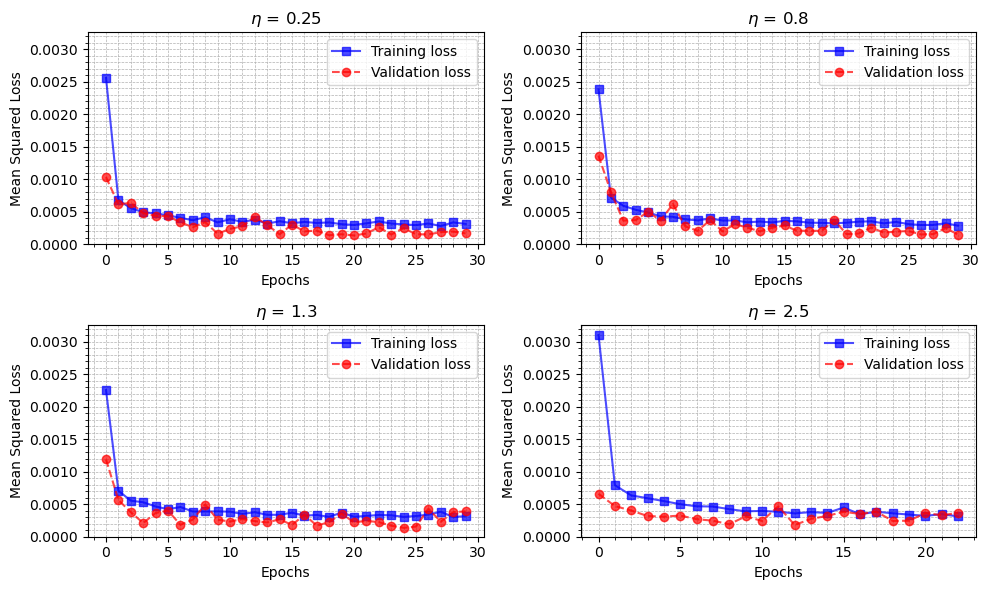

In [47]:
plot_learning_curves(loss_history_eta, title_prefix='$\eta$')

## 4.3. Extension to Learning $\eta$

### fBm processes

In this section, we use fBm processes instead of rBergomi processses, discretized $H$

In [21]:
T = 1
n_timesteps = 100
n_paths = 5000

kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Different methods for generating Hurst indices
samplers = ['discretized', 'uniform', 'beta']

# Initialize DataFrame to store benchmark results for different Hurst index samplers
report_fbm = pd.DataFrame(columns=['RMSE(CNN)', 'MRE(CNN)', 'Training Time (seconds)', 'Test Time (seconds)',
                                   'RMSE(LS)', 'MRE(LS)', 'Time (seconds)'], index=samplers)
report_fbm.index.name = 'H sampler'

# Dictionary to store loss history for each sampler method
loss_history_fbm = {}

for sampler in samplers:
    logging.info(f"Performing H sampler: {sampler}")
    Hs = generate_h_values(method=sampler) 
    X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(Hs, method='fbm', n_paths=n_paths, n_timesteps=n_timesteps, T=T)

    report, loss_history, model = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                     kernel_size, pool_size, leaky_rate, batch_size, n_epochs, time_steps=[100])
    report_fbm.loc[sampler, :] = report.iloc[0, :]  # Capture only the first row as only one time step of 100 is used
    loss_history_fbm[sampler] = loss_history[100]  # Store loss history for the specific sampler

2024-05-03 06:57:24,865 - INFO - Performing H sampler: discretized
2024-05-03 06:57:25,219 - INFO - Processing 100 time steps
2024-05-03 06:57:25,259 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


2024-05-03 06:59:15,454 - INFO - Evaluating Least Squares
2024-05-03 06:59:37,626 - INFO - Performing H sampler: uniform
2024-05-03 06:59:38,407 - INFO - Processing 100 time steps
2024-05-03 06:59:38,451 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


2024-05-03 07:02:18,730 - INFO - Evaluating Least Squares
2024-05-03 07:02:40,877 - INFO - Performing H sampler: beta
2024-05-03 07:02:41,742 - INFO - Processing 100 time steps
2024-05-03 07:02:41,795 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


2024-05-03 07:05:43,762 - INFO - Evaluating Least Squares


In [24]:
report_fbm

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
H sampler,,,,,,,
discretized,0.015874,0.036418,107.535554,2.658239,0.096421,0.248683,22.168354
uniform,0.013735,0.024986,158.901812,1.37375,0.105528,0.239881,22.143747
beta,0.013292,0.095342,180.076823,1.887663,0.051348,0.399874,22.051397


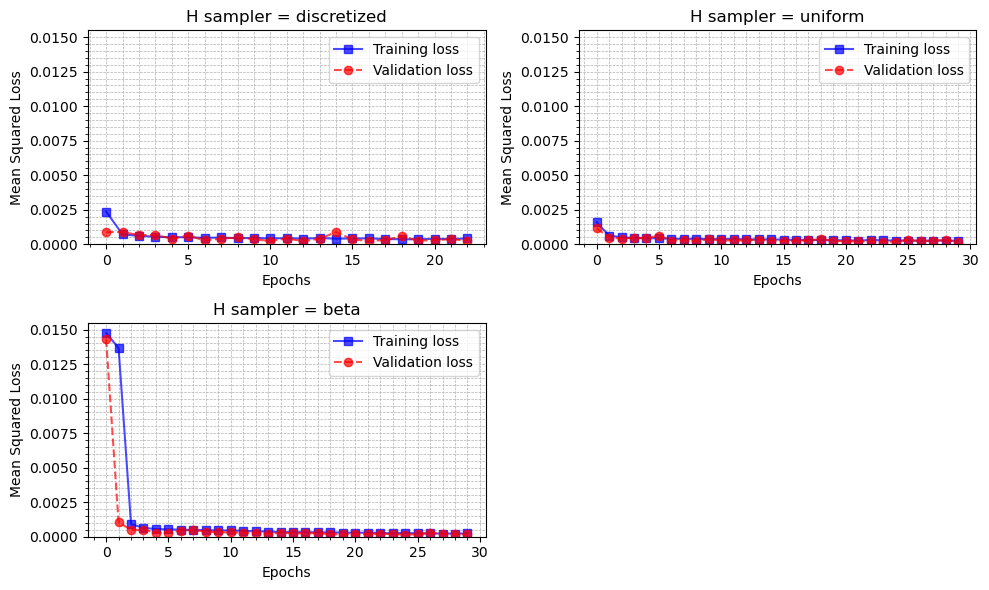

In [25]:
plot_learning_curves(loss_history_fbm, title_prefix='H sampler')

### Robustness Test: random $\eta$ and $H$

In this section, we allow both $\eta$ and $H$ to vary during the sample generation.

In [61]:
T = 1
n_timesteps = 100
n_paths = 25000

kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Begin path generation with random eta and H values
logging.info("Generating paths with random eta and H")
paths, labels, etas = generate_rBergomi_random_paths(n_paths, n_timesteps) 

# Shuffle and split the data into training, validation, and testing sets
X_train, X_val, X_test, Y_train, Y_val, Y_test = shuffle_and_split_data(paths, labels)

# Run benchmark to evaluate the neural network and compare with least squares method
report, loss_history, model = benchmark(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                 kernel_size, pool_size, leaky_rate, batch_size, n_epochs, time_steps=[100])

2024-05-03 04:02:51,634 - INFO - Generating paths with random eta and H
2024-05-03 04:09:15,530 - INFO - Processing 100 time steps
2024-05-03 04:09:15,563 - INFO - Training CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-05-03 04:09:45,701 - INFO - Evaluating Least Squares


In [62]:
report

,RMSE(CNN),MRE(CNN),Training Time (seconds),Test Time (seconds),RMSE(LS),MRE(LS),Time (seconds)
Input length,,,,,,,
100,0.037356,0.269273,29.596065,0.539881,0.053237,0.381562,7.983818


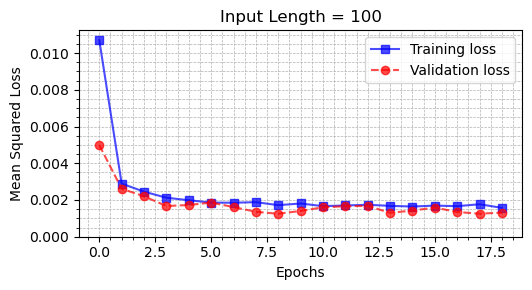

In [63]:
plot_learning_curves(loss_history, title_prefix='Input Length')

### Learning $\eta$ and $H$

In this section, we try to make the CNN to predict $H$ and $\eta$ at the same time.

In [27]:
# Set simulation parameters
T = 1
n_timesteps = 100
n_paths = 25000

logging.info("Generating paths with random eta and H")
paths, Hs, etas = generate_rBergomi_random_paths(n_paths, n_timesteps) 
labels = np.column_stack((Hs, etas))  # Combine Hs and etas into a single label array

# Shuffle and split the data
X_train, X_val, X_test, Y_train, Y_val, Y_test = shuffle_and_split_data(paths, labels)
logging.info("Data prepared")

# Neural network configuration
kernel_size = 20
pool_size = 3
leaky_rate = 0.1
batch_size = 64
n_epochs = 30

# Prepare reporting structure
report = pd.DataFrame(columns=['H-RMSE(CNN)', 'eta-RMSE(CNN)', 'H-MRE(CNN)', 'eta-MRE(CNN)', 
                               'Training Time (seconds)', 'Test Time (seconds)', 
                               'H-RMSE(LS)', 'eta-RMSE(LS)', 'H-MRE(LS)', 'eta-MRE(LS)', 'Time (seconds)'],
                      index=[100])
report.index.name = 'Input length'
loss_history = {}

# Build and compile the neural network
model = Sequential([
    Conv1D(32, kernel_size, activation='linear', padding='same', input_shape=(n_timesteps, 1)),
    LeakyReLU(alpha=leaky_rate),
    MaxPooling1D(pool_size, padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(2, activation='linear')  
])
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
logging.info("Running CNN")
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
cnn_train = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, 
                      validation_data=(X_val, Y_val), callbacks=[early_stopping])
cnn_train_time = time.time() - start_time
report.loc[100, 'Training Time (seconds)'] = cnn_train_time

# Evaluate the model
start_time = time.time()
cnn_pred = model.predict(X_test)
cnn_test_time = time.time() - start_time
report.loc[100, 'Test Time (seconds)'] = cnn_test_time
report.loc[100, ['H-RMSE(CNN)', 'eta-RMSE(CNN)']] = np.sqrt(mean_squared_error(Y_test, cnn_pred, multioutput='raw_values'))
report.loc[100, ['H-MRE(CNN)', 'eta-MRE(CNN)']] = mean_absolute_error(Y_test, cnn_pred, multioutput='raw_values') / np.mean(Y_test, axis=0)

loss_history[100] = {
    'train_loss': cnn_train.history['loss'],
    'val_loss': cnn_train.history['val_loss']
}

# Execute least squares fitting
logging.info("Running Least Squares")
start_time = time.time()
ls_pred = perform_least_squares(X_test) 
ls_time = time.time() - start_time
report.loc[100, 'Time (seconds)'] = ls_time
report.loc[100, ['H-RMSE(LS)', 'eta-RMSE(LS)']] = np.sqrt(mean_squared_error(Y_test, ls_pred, multioutput='raw_values'))
report.loc[100, ['H-MRE(LS)', 'eta-MRE(LS)']] = mean_absolute_error(Y_test, ls_pred, multioutput='raw_values') / np.mean(Y_test, axis=0)

2024-05-03 07:09:45,467 - INFO - Generating paths with random eta and H
2024-05-03 07:23:50,532 - INFO - Data prepared
C:\Users\uknad\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\uknad\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-05-03 07:23:50,560 - INFO - Running CNN


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-05-03 07:24:27,601 - INFO - Running Least Squares


In [28]:
report

,H-RMSE(CNN),eta-RMSE(CNN),H-MRE(CNN),eta-MRE(CNN),Training Time (seconds),Test Time (seconds),H-RMSE(LS),eta-RMSE(LS),H-MRE(LS),eta-MRE(LS),Time (seconds)
Input length,,,,,,,,,,,
100,0.066641,0.278271,0.490325,0.139053,36.308233,0.725387,0.053871,1.713386,0.385873,0.996022,22.381272


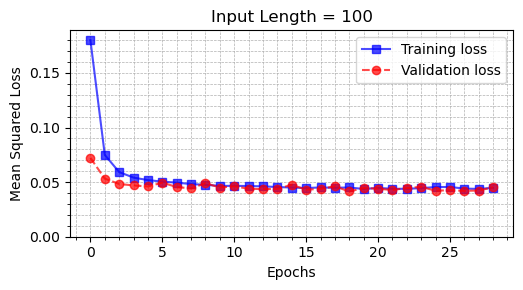

In [29]:
plot_learning_curves(loss_history, title_prefix='Input Length')

## 4.4. Robustness test on a (mean-reverting) Ornstein-Uhlenbeck process

$$
\mathrm{d} X_t=\left(a-b X_t\right) \mathrm{d} t+c X_t \mathrm{~d} W_t, \quad X_0=x_0 \in \mathbb{R},
$$
where $W$ is a standard Brownian motion, and that $X$ is $\gamma$-Hölder continuous for all $\gamma \in(0,1 / 2)$; therefore we expect both approaches to estimate $H \approx 0.5$.

We set the input length to be 100 for the CNN, using the Discretised and Uniform $H$ sampling methods detailed above. Each trained network is then used to estimate $H$ on trajectories of a (mean-reverting) Ornstein-Uhlenbeck process, which are simulated using the Euler-Maruyama method. We simulate 1000 trajectories of length 100 , setting $\left(x_0, a, b\right)=(0.1,1 ., 2.1)$, and report the mean estimated $H$ values for the CNN and LS approaches in Table 9 below, for the 'high volatity' $(c=3)$ and 'low volatility' $(c=0.3)$ regimes.

In [73]:
# Parameters
n_paths = 1000
n_timesteps = 100
dt = 0.01  # Time step
x0 = 0.1   # Initial value
a = 1.0    # Drift coefficient
b = 2.1    # Mean-reversion coefficient
cs = [3, 0.3]  # Volatility parameters for high and low volatility regimes

model_h_discretized = 'cnn_model_discretized.keras'
model_h_uniform = 'cnn_model_uniform.keras'

# Function to simulate Ornstein-Uhlenbeck process
def simulate_ou_process(x0, a, b, c, dt, n_timesteps, n_paths):
    paths = np.zeros((n_paths, n_timesteps))
    paths[:, 0] = x0
    for t in range(1, n_timesteps):
        dw = np.random.normal(scale=np.sqrt(dt), size=n_paths)
        paths[:, t] = paths[:, t-1] + (a - b * paths[:, t-1]) * dt + c * paths[:, t-1] * dw
    return paths

# Load trained CNN models
model_discretized = load_model(model_h_discretized)
model_uniform = load_model(model_h_uniform)

# Gather results
results = {c: {'CNN_Discretised': None, 'CNN_Uniform': None, 'LS': None} for c in cs}

for c in cs:
    paths = simulate_ou_process(x0, a, b, c, dt, n_timesteps, n_paths)
    paths_reshaped = paths.reshape((n_paths, n_timesteps, 1))

    # Predict H using different models
    h_cnn_discretized = model_discretized.predict(paths_reshaped).flatten()
    h_cnn_uniform = model_uniform.predict(paths_reshaped).flatten()

    # Estimating H using Least Squares for comparison
    h_ls = perform_least_squares(paths)[:, 0]

    # Store results
    results[c]['CNN_Discretised'] = np.mean(h_cnn_discretized)
    results[c]['CNN_Uniform'] = np.mean(h_cnn_uniform)
    results[c]['LS'] = np.mean(h_ls)

# Convert results to DataFrame
df_results = pd.DataFrame(results).transpose()

C:\Users\uknad\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [74]:
df_results

,CNN_Discretised,CNN_Uniform,LS
3.0,0.408889,0.395917,0.229948
0.3,0.499870,0.490969,0.672207


## 5. Calibration using CNNs

We begin by using the trained CNNs from Section 4 to predict the Hölder exponent of historic realised volatility data from the Oxford-Man Institute of Quantitative Finance, which is free and publicly available (since the url not working, we used instead https://github.com/andymogul/SpilloverVolPrediction downloaded at August 2022). We choose the length of the input vectors to be 100.

In [76]:
model_discretized = load_model('cnn_model_discretized.keras')
model_uniform = load_model('cnn_model_uniform.keras')
model_beta = load_model('cnn_model_beta.keras')

# Load the CSV data
data = pd.read_csv('rv_dataset.csv') # source: https://github.com/andymogul/SpilloverVolPrediction

# Function to create input vectors of length 100 from index data
def create_input_vectors(data, window_size=100):
    vectors = []
    for i in range(len(data) - window_size + 1):
        vectors.append(data[i:i+window_size])
    return np.array(vectors)

# Function to predict Hölder exponent using CNN model
def predict_holder_exponent(model, data):
    # Reshape data for model input
    data = data.reshape((data.shape[0], data.shape[1], 1))
    return model.predict(data).flatten()

# Analyze indices
indices = ['.SPX', '.GDAXI', '.FCHI', '.FTSE', '.OMXSPI', '.N225', '.KS11', '.HSI']

results = {
    'Discretised H': [],
    'H ~ Uniform (0.0, 0.5)': [],
    'H ~ Beta(1, 9)': []
}

for index in indices:
    index_data = data[index].values
    input_vectors = create_input_vectors(index_data)
    holder_discretized = predict_holder_exponent(model_discretized, input_vectors)
    holder_uniform = predict_holder_exponent(model_uniform, input_vectors)
    holder_beta = predict_holder_exponent(model_beta, input_vectors)
    holder_ls = perform_least_squares(input_vectors)[:, 0]
    
    results['Discretised H'].append((np.sqrt(mean_squared_error(holder_discretized, holder_ls)), np.std(holder_discretized - holder_ls)))
    results['H ~ Uniform (0.0, 0.5)'].append((np.sqrt(mean_squared_error(holder_uniform, holder_ls)), np.std(holder_uniform - holder_ls)))
    results['H ~ Beta(1, 9)'].append((np.sqrt(mean_squared_error(holder_beta, holder_ls)), np.std(holder_beta - holder_ls)))

# Compute average RMSE and std dev for each method
final_results = {}
for method in results:
    rmse, std_dev = zip(*results[method])
    final_results[method] = {'Root Mean Square Error': f"{np.mean(rmse):.3e}", 'Standard Deviation': f"{np.mean(std_dev):.3e}"}

df_results = pd.DataFrame(final_results).transpose()
df_results.index.name = 'Sampling Method'
df_results.reset_index(inplace=True)

# Display the results
df_results

C:\Users\uknad\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


,Sampling Method,Root Mean Square Error,Standard Deviation
0,Discretised H,4.235e-01,5.842e-02
1,"H ~ Uniform (0.0, 0.5)",4.157e-01,5.844e-02
2,"H ~ Beta(1, 9)",1.867e-01,5.845e-02
